In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from neuralop import LpLoss, H1Loss
from neuralop import Trainer as Trainer_1
from neuralop.training import AdamW
from neuralop.models import FNO1d
from models.fno1d_activation import FNO1d_activation
from torch.utils.data import DataLoader
from data.tecplot import *
from utils.utils import *

os.environ["CUDA_VISIBLE_DEVICES"]="0" 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
args = objectview({
    'model' : FNO1d,
    'model_args': {
        'n_modes_height' : 128,
        'hidden_channels' : 256,
        'in_channels' : 15,
        'out_channels' : 3,
        'n_layers' : 10,
        # 'post_activation' : torch.nn.functional.tanh
    },
    'train_args': {
        'device' : torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
        'optimizer' : AdamW,
        'lr' : 1e-3,
        'weight_decay' : 1e-4,
        'scheduler' : torch.optim.lr_scheduler.CosineAnnealingLR,
        'loss' : H1Loss(d=2),
        'trainer' : Trainer_1,
        'n_epochs' : 5000,
    },
    'validate_args': {
        'device' : torch.device('cpu')
    }
})

In [3]:
data_names = [
    '../data/it01rh_400-500_slice_trachea.dat',
    '../data/it01rh_501-600_slice_trachea.dat',
    '../data/it01rh_601-700_slice_trachea.dat',
    '../data/it01rh_701-800_slice_trachea.dat'
]
dataset = load_tecplot_to_pt_dataset(
    root_dir='../data/',
    dataset_name='tecplot_slice',
    n_train=300, 
    n_test=50, 
    resolution='medium',
    batch_size=10,
    normalize=True,
    file_names=data_names,
)

In [ ]:
loader = DataLoader(
    dataset.train_db, 
    batch_size=5, 
    num_workers=0, 
    pin_memory=False, 
    persistent_workers=False
)

In [5]:
model = args.model(**args.model_args).to(args.train_args['device'])
optimizer = args.train_args['optimizer'](
    model.parameters(), 
    lr=args.train_args['lr'], 
    weight_decay=args.train_args['weight_decay']
)
if args.train_args['scheduler'] is not None:
    scheduler = args.train_args['scheduler'](optimizer, T_max=60)
train_loss = args.train_args['loss']

In [6]:
trainer = args.train_args['trainer'](
    model = model,
    n_epochs = args.train_args['n_epochs'],
    # wandb_log = True,
    device = args.train_args['device'],
    verbose = True
)
trainer.train(
    train_loader = loader,
    test_loaders = {},
    optimizer = optimizer,
    scheduler = scheduler,
    regularizer = False,
    training_loss = train_loss,
    save_every = 1,
    save_dir = '../checkpoints/'
)

Training on 300 samples
Testing on [] samples         on resolutions [].


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.73 GiB. GPU 0 has a total capacity of 31.73 GiB of which 2.54 GiB is free. Including non-PyTorch memory, this process has 29.19 GiB memory in use. Of the allocated memory 26.50 GiB is allocated by PyTorch, and 2.29 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
model = args.model(**args.model_args).to(args.validate_args['device'])
model.load_state_dict(torch.load('../checkpoints/model_state_dict.pt', weights_only=False))

<All keys matched successfully>

In [ ]:
data = next(iter(loader))
output = recurrent_formulation(
    model,
    initial_input=data['x'][0].unsqueeze(0).float().to(device),
    n_iteration=20,
    n_timesteps=5,
    n_variables=3,
    device=torch.device('cpu'),
)

In [ ]:
output

tensor([[[[-3.7247e-01, -3.7357e-01, -3.7235e-01,  ..., -3.5627e-01,
           -3.6560e-01, -3.5388e-01],
          [-3.0546e-01, -3.0540e-01, -3.0621e-01,  ..., -3.5367e-01,
           -3.2565e-01, -3.5033e-01],
          [ 2.8617e-01,  2.8475e-01,  2.8450e-01,  ...,  2.5220e-01,
            2.7044e-01,  2.6692e-01],
          ...,
          [-1.7741e+04, -1.7614e+04, -1.7490e+04,  ..., -1.8039e+04,
           -1.7955e+04, -1.7869e+04],
          [-2.7681e+04, -2.7930e+04, -2.8197e+04,  ..., -2.6996e+04,
           -2.7209e+04, -2.7440e+04],
          [ 3.8863e+05,  3.9121e+05,  3.9378e+05,  ...,  3.8086e+05,
            3.8348e+05,  3.8605e+05]],

         [[-4.1958e-01, -4.2046e-01, -4.1834e-01,  ..., -5.6951e-01,
           -5.3754e-01, -5.5800e-01],
          [ 5.2457e-02,  5.2819e-02,  5.1984e-02,  ..., -1.4681e-01,
           -1.2975e-01, -1.2771e-01],
          [ 2.1355e+00,  2.1343e+00,  2.1346e+00,  ...,  2.0727e+00,
            2.0914e+00,  2.0794e+00],
          ...,
     

torch.Size([10, 3, 78083])


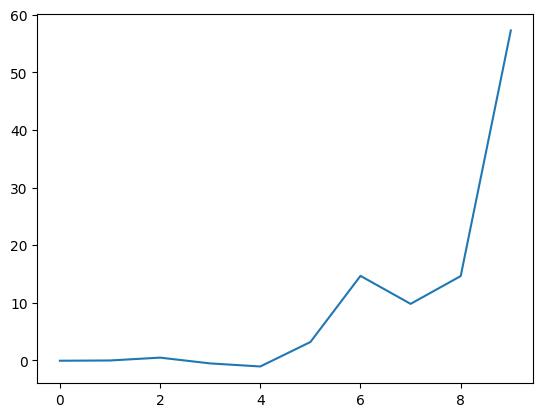

In [ ]:
import matplotlib.pyplot as plt

y = output[0,2,:10,700].detach().numpy()

yy = data['y']
print(yy.shape)
yy = yy[]
plt.plot(y)
# plt.plot(yy)
plt.show()